In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [5]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from torch.nn import L1Loss
from tqdm import tqdm

import h5py
import numpy as np
from matplotlib import pyplot as plt

import fastmri
from fastmri.data import transforms as T

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

from generative.inferers import LatentDiffusionInferer
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.3.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /home/<username>/jupyter1/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.3.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 9.0.0.post1
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: 0.18.0
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please vi

In [3]:
# for reproducibility purposes set a seed
set_determinism(42)

In [4]:
# setup a data directory and download dataset
directory = 'fastMRIData'
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

fastMRIData


In [5]:
# prepare data loader for training set
batch_size = 2
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[channel, :, :, :]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.EnsureTyped(keys=["image"]),
        transforms.Orientationd(keys=["image"], axcodes="RAS"),
        transforms.Spacingd(keys=["image"], pixdim=(2.4, 2.4, 2.2), mode=("bilinear")),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=(96, 96, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
    ]
)
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=8,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')

Loading dataset: 100%|██████████| 388/388 [04:08<00:00,  1.56it/s]

Image shape torch.Size([1, 96, 96, 64])



/home/stephie/jupyter1/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


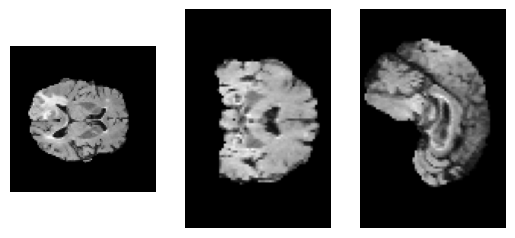

In [10]:
# Visualise examples from the training set
# Plot axial, coronal and sagittal slices of a training sample
check_data = first(train_loader)
idx = 0

img = check_data["image"][idx, 0]
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")
plt.savefig("training_examples.png")

In [7]:
# Defining the autoencoder KL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [8]:
autoencoder = AutoencoderKL(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=(32, 64, 64),
    latent_channels=3,
    num_res_blocks=1,
    norm_num_groups=16,
    attention_levels=(False, False, True),
)
autoencoder.to(device)


discriminator = PatchDiscriminator(spatial_dims=3, num_layers_d=3, num_channels=32, in_channels=1, out_channels=1)
discriminator.to(device)

PatchDiscriminator(
  (initial_conv): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (adn): ADN(
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (0): Convolution(
    (conv): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): Convolution(
    (conv): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): Convolution(
    (conv): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1), bias=Fal

In [9]:
# Defining losses
l1_loss = L1Loss()
adv_loss = PatchAdversarialLoss(criterion="least_squares")
loss_perceptual = PerceptualLoss(spatial_dims=3, network_type="squeeze", is_fake_3d=True, fake_3d_ratio=0.2)
loss_perceptual.to(device)


def KL_loss(z_mu, z_sigma):
    kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3, 4])
    return torch.sum(kl_loss) / kl_loss.shape[0]


adv_weight = 0.01
perceptual_weight = 0.001
kl_weight = 1e-6

/home/stephie/jupyter1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/stephie/jupyter1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
optimizer_g = torch.optim.Adam(params=autoencoder.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=1e-4)

In [ ]:
# Train model
n_epochs = 100
autoencoder_warm_up_n_epochs = 5
val_interval = 10
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(n_epochs):
    autoencoder.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)  # choose only one of Brats channels

        # Generator part
        optimizer_g.zero_grad(set_to_none=True)
        reconstruction, z_mu, z_sigma = autoencoder(images)
        kl_loss = KL_loss(z_mu, z_sigma)

        recons_loss = l1_loss(reconstruction.float(), images.float())
        p_loss = loss_perceptual(reconstruction.float(), images.float())
        loss_g = recons_loss + kl_weight * kl_loss + perceptual_weight * p_loss

        if epoch > autoencoder_warm_up_n_epochs:
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g += adv_weight * generator_loss

        loss_g.backward()
        optimizer_g.step()

        if epoch > autoencoder_warm_up_n_epochs:
            # Discriminator part
            optimizer_d.zero_grad(set_to_none=True)
            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

            loss_d = adv_weight * discriminator_loss

            loss_d.backward()
            optimizer_d.step()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))

del discriminator
del loss_perceptual
torch.cuda.empty_cache()

Epoch 0:   0%|                                                                        | 0/194 [00:00<?, ?it/s]/home/stephie/jupyter1/lib/python3.11/site-packages/torch/_tensor.py:1443: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /home/coulombc/wheels_builder/tmp.2617/python-3.11/torch/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  ret = func(*args, **kwargs)
/home/stephie/jupyter1/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /home/coulombc/wheels_builder/tmp.2617/python-3.11/torch/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 11:  59%|█████▎ 

NameError: name 'epoch_recon_loss_list' is not defined

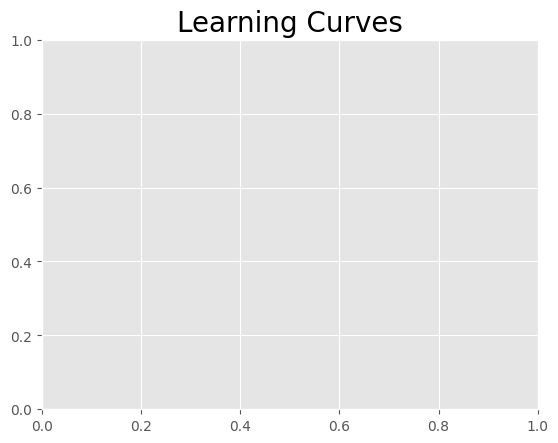

In [11]:
# Plot training curve
plt.style.use("ggplot")
plt.title("Learning Curves", fontsize=20)
plt.plot(epoch_recon_loss_list)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.savefig('learning_curves.png', bbox_inches='tight')
# writer.add_graph();

In [ ]:
# Adversarial Training Curve Plot
plt.title("Adversarial Training Curves", fontsize=20)
plt.plot(epoch_gen_loss_list, color="C0", linewidth=2.0, label="Generator")
plt.plot(epoch_disc_loss_list, color="C1", linewidth=2.0, label="Discriminator")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.savefig('adversarial_training_curve.png', bbox_inches='tight')

In [ ]:
# Visualize reconstructions
# Plot axial, coronal and sagittal slices of a training sample
idx = 0
img = reconstruction[idx, channel].detach().cpu().numpy()
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")
plt.savefig('reconstructions.png')

In [ ]:
#Diffusion model
# Define diffusion model and scheduler
unet = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=3,
    out_channels=3,
    num_res_blocks=1,
    num_channels=(32, 64, 64),
    attention_levels=(False, True, True),
    num_head_channels=(0, 64, 64),
)
unet.to(device)


scheduler = DDPMScheduler(num_train_timesteps=50, schedule="scaled_linear_beta", beta_start=0.0015, beta_end=0.0195)

In [ ]:
# Scaling factor
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoder.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

In [ ]:
# Define inferer using scaling factor
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

In [ ]:
optimizer_diff = torch.optim.Adam(params=unet.parameters(), lr=1e-4)

In [ ]:
# Train diffusion model
n_epochs = 150
epoch_loss_list = []
autoencoder.eval()
scaler = GradScaler()

first_batch = first(train_loader)
z = autoencoder.encode_stage_2_inputs(first_batch["image"].to(device))

for epoch in range(n_epochs):
    unet.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_diff.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(z).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(
                inputs=images, autoencoder_model=autoencoder, diffusion_model=unet, noise=noise, timesteps=timesteps
            )

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer_diff)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

In [ ]:
# Learning curves plot
plt.plot(epoch_loss_list)
plt.title("Learning Curves", fontsize=20)
plt.plot(epoch_loss_list)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.savefig('LDM_learning_curves.png', bbox_inches='tight')
# plt.show()

In [ ]:
# Plotting sampling example
autoencoder.eval()
unet.eval()

noise = torch.randn((1, 3, 24, 24, 16))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=5)
synthetic_images = inferer.sample(
    input_noise=noise, autoencoder_model=autoencoder, diffusion_model=unet, scheduler=scheduler
)

In [ ]:
# Visualize synthesized data
idx = 0
img = synthetic_images[idx, channel].detach().cpu().numpy()  # images
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")
plt.savefig('synthesized_data.png')

In [ ]:
# Clean up data
if directory is None:
    shutil.rmtree(root_dir)